# Requirements

## library installation

In [ ]:
!pip install google-cloud-storage #rasterio

from google.colab import auth
auth.authenticate_user()

import os
from google.cloud import storage
# import rasterio
import numpy as np
import yaml
import io

# Setup Google Cloud Storage client
client = storage.Client()
bucket_name = 'cbdcrop'
bucket = client.get_bucket(bucket_name)

In [ ]:
# Install required packages (using versions compatible with TF 2.18.0)
# !pip install --upgrade numpy scipy keras-unet-collection

# Verify installations
import tensorflow as tf
import numpy as np
import scipy
print(f"TensorFlow version: {tf.__version__}")  # Should show 2.18.0
print(f"NumPy version: {np.__version__}")      # Should show 1.25.2 or similar
print(f"SciPy version: {scipy.__version__}")   # Should show 1.11.4 or similar

# Check GPU availability
!nvidia-smi

TensorFlow version: 2.18.0
NumPy version: 2.0.2
SciPy version: 1.14.1
Thu Apr 17 07:01:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |  

In [ ]:
import os
!mkdir unet
os.chdir('/content/unet')

print(os.getcwd())

/content/unet


## Image Upload tfrecord

In [ ]:
# os.chdir('/content/unet/train_2023_m3')
# !gsutil -m cp -r gs://cbdcrop/tfrecord_data/planet/train_2023_m3/ /content/unet/
# !gsutil -m cp -r gs://cbdcrop/tfrecord_data/planet/train_2023_m3_m7/ /content/unet/
# !gsutil -m cp -r gs://cbdcrop/unet/model_weight /content/unet/




Streaming output truncated to the last 5000 lines.
Copying gs://cbdcrop/tfrecord_data/planet/train_2023_m3/tfrecord_cassava_2023_m31/patch_KPT_04141.tfrecord.gz...
Copying gs://cbdcrop/tfrecord_data/planet/train_2023_m3/tfrecord_cassava_2023_m31/patch_KPT_04143.tfrecord.gz...
Copying gs://cbdcrop/tfrecord_data/planet/train_2023_m3/tfrecord_cassava_2023_m31/patch_KPT_04140.tfrecord.gz...
Copying gs://cbdcrop/tfrecord_data/planet/train_2023_m3/tfrecord_cassava_2023_m31/patch_KPT_04139.tfrecord.gz...
Copying gs://cbdcrop/tfrecord_data/planet/train_2023_m3/tfrecord_cassava_2023_m31/patch_KPT_04138.tfrecord.gz...
Copying gs://cbdcrop/tfrecord_data/planet/train_2023_m3/tfrecord_cassava_2023_m31/patch_KPT_04144.tfrecord.gz...
Copying gs://cbdcrop/tfrecord_data/planet/train_2023_m3/tfrecord_cassava_2023_m31/patch_KPT_04142.tfrecord.gz...
Copying gs://cbdcrop/tfrecord_data/planet/train_2023_m3/tfrecord_cassava_2023_m31/patch_KPT_04145.tfrecord.gz...
Copying gs://cbdcrop/tfrecord_data/planet/tra

## GPU Setting

In [ ]:
# Uninstall default TensorFlow
!pip uninstall -y tensorflow

# Install TensorFlow with GPU support (latest stable version as of March 2025)
!pip install tensorflow[and-cuda]

# Restart runtime after installation
import os
os.kill(os.getpid(), 9)  # This restarts the Colab runtime programmatically

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.21.5
    Uninstalling nvidia-nccl-cu12-2.21.5:
      Successfully uninstalled nvidia-nccl-cu12-2.21.5
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
ERROR: pip's dependency res

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU Name: {gpu.name}")
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs detected.")

TensorFlow version: 2.19.0
GPUs detected: 1
GPU Name: /physical_device:GPU:0


# Training

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import os, glob

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Name: {gpu.name}")
    print("GPU(s) will be used for training.")
else:
    print("No GPUs detected. Falling back to CPU.")

# Model and training configuration
BANDS = ['input_image1', 'input_image2', 'input_image3', 'input_image4', 'input_image5']
LABEL = 'class_patch'
FEATURES = BANDS + [LABEL]
BATCH_SIZE = 64
EPOCHS = 50
BUFFER_SIZE = 1024
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

IMAGE_SHAPES = {
    'input_image1': (256, 256, 4),
    'input_image2': (128, 128, 4),
    'input_image3': (64, 64, 6),
    'input_image4': (128, 128, 4),
    'input_image5': (32, 32, 7),
    'class_patch': (256, 256, 1)
}

optimizer = tf.keras.optimizers.Adam()

# Data Preparation Functions
def decode_and_reshape(parsed_features):
    for key, shape in IMAGE_SHAPES.items():
        parsed_features[key] = tf.io.decode_raw(parsed_features[key], tf.float32)
        parsed_features[key] = tf.reshape(parsed_features[key], shape)
    return parsed_features

def _parse_function(proto):
    keys_to_features = {key: tf.io.FixedLenFeature([], tf.string) for key in IMAGE_SHAPES.keys()}
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    parsed_features = decode_and_reshape(parsed_features)
    labels_inverse = tf.math.abs(parsed_features['class_patch'] - 1)
    labels = tf.concat([labels_inverse, parsed_features['class_patch']], axis=-1)
    parsed_features['class_patch'] = tf.reshape(parsed_features['class_patch'], (256, 256))
    CLASS_NUM = 2
    labels = tf.one_hot(tf.cast(parsed_features['class_patch'], tf.int32), CLASS_NUM)
    inputs = {key: parsed_features[key] for key in IMAGE_SHAPES.keys() if key != 'class_patch'}
    return inputs, labels

def _input_function(filenames):
    dataset = tf.data.TFRecordDataset(filenames, compression_type='GZIP', num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.apply(tf.data.experimental.ignore_errors())  # Gunakan apply untuk debugging
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def get_dataset_size(filenames):
    dataset = _input_function(filenames)
    return sum(1 for _ in dataset)

class AttentionUNet:
    def __init__(self):
        # Inisialisasi parameter dasar
        self.img_shape = (None, None, 4)  # Bentuk input gambar (fleksibel, 4 saluran)
        self.df = 32  # Filter untuk downsampling (konvolusi)
        self.uf = 32  # Filter untuk upsampling (dekonvolusi)

    def build_unet(self):
        # Fungsi bantu untuk lapisan konvolusi ganda
        def conv_block(input_layer, filters, dropout_rate=0, use_bn=False, name_prefix=""):
            x = layers.Conv2D(filters, (3, 3), padding='same', name=f"{name_prefix}_conv1")(input_layer)
            if use_bn:
                x = layers.BatchNormalization(name=f"{name_prefix}_bn1")(x)
            x = layers.Activation('relu', name=f"{name_prefix}_relu1")(x)
            x = layers.Conv2D(filters, (3, 3), padding='same', name=f"{name_prefix}_conv2")(x)
            if use_bn:
                x = layers.BatchNormalization(name=f"{name_prefix}_bn2")(x)
            x = layers.Activation('relu', name=f"{name_prefix}_relu2")(x)
            if dropout_rate > 0:
                x = layers.Dropout(dropout_rate, name=f"{name_prefix}_dropout")(x)
            return x

        # Fungsi bantu untuk lapisan upsampling
        def upsample_block(input_layer, filters, use_bn=False, name_prefix=""):
            x = layers.UpSampling2D((2, 2), name=f"{name_prefix}_upsample")(input_layer)
            x = layers.Conv2D(filters, (3, 3), padding='same', name=f"{name_prefix}_conv")(x)
            if use_bn:
                x = layers.BatchNormalization(name=f"{name_prefix}_bn")(x)
            x = layers.Activation('relu', name=f"{name_prefix}_relu")(x)
            return x

        # Fungsi bantu untuk blok perhatian (attention gate)
        def attention_gate(gating_signal, skip_connection, inter_filters, use_bn=False, name_prefix=""):
            g = layers.Conv2D(inter_filters, (1, 1), padding='valid', name=f"{name_prefix}_conv_g")(gating_signal)
            if use_bn:
                g = layers.BatchNormalization(name=f"{name_prefix}_bn_g")(g)
            x = layers.Conv2D(inter_filters, (1, 1), padding='valid', name=f"{name_prefix}_conv_x")(skip_connection)
            if use_bn:
                x = layers.BatchNormalization(name=f"{name_prefix}_bn_x")(x)
            psi = layers.Add(name=f"{name_prefix}_add")([g, x])
            psi = layers.Activation('relu', name=f"{name_prefix}_relu")(psi)
            psi = layers.Conv2D(1, (1, 1), padding='valid', name=f"{name_prefix}_conv_psi")(psi)
            if use_bn:
                psi = layers.BatchNormalization(name=f"{name_prefix}_bn_psi")(psi)
            psi = layers.Activation('sigmoid', name=f"{name_prefix}_sigmoid")(psi)
            return layers.Multiply(name=f"{name_prefix}_multiply")([skip_connection, psi])

        # Definisikan input untuk berbagai ukuran gambar
        with tf.device('/GPU:0'):  # Pastikan pemrosesan di GPU
            input_256 = layers.Input(shape=self.img_shape, name="input_image1")  # 256x256x4
            input_128 = layers.Input(shape=self.img_shape, name="input_image2")  # 128x128x4
            input_64 = layers.Input(shape=(None, None, 6), name="input_image3")  # 64x64x6
            input_128s1 = layers.Input(shape=self.img_shape, name="input_image4")  # 128x128x4
            input_32 = layers.Input(shape=(None, None, 7), name="input_image5")  # 32x32x7

            # Encoder (Downsampling Path)
            # Level 1: 256x256 -> 128x128
            conv1 = conv_block(input_256, self.df, name_prefix="conv1")
            pool1 = layers.MaxPooling2D((2, 2), name="pool1")(conv1)
            concat1 = layers.Concatenate(name="concat1")([pool1, input_128, input_128s1])

            # Level 2: 128x128 -> 64x64
            conv2 = conv_block(concat1, self.df * 2, use_bn=True, name_prefix="conv2")
            pool2 = layers.MaxPooling2D((2, 2), name="pool2")(conv2)
            concat2 = layers.Concatenate(name="concat2")([pool2, input_64])

            # Level 3: 64x64 -> 32x32
            conv3 = conv_block(concat2, self.df * 4, use_bn=True, name_prefix="conv3")
            pool3 = layers.MaxPooling2D((2, 2), name="pool3")(conv3)
            concat3 = layers.Concatenate(name="concat3")([pool3, input_32])

            # Level 4: 32x32 -> 16x16
            conv4 = conv_block(concat3, self.df * 8, dropout_rate=0.5, use_bn=True, name_prefix="conv4")
            pool4 = layers.MaxPooling2D((2, 2), name="pool4")(conv4)

            # Bottleneck: 16x16
            conv5 = conv_block(pool4, self.df * 16, dropout_rate=0.5, use_bn=True, name_prefix="conv5")

            # Decoder (Upsampling Path)
            # Level 4: 16x16 -> 32x32
            up6 = upsample_block(conv5, self.uf * 8, use_bn=True, name_prefix="up6")
            att6 = attention_gate(up6, conv4, self.uf * 8, use_bn=True, name_prefix="att6")
            concat6 = layers.Concatenate(name="concat6")([up6, att6])
            conv6 = conv_block(concat6, self.uf * 8, name_prefix="conv6")

            # Level 3: 32x32 -> 64x64
            up7 = upsample_block(conv6, self.uf * 4, use_bn=True, name_prefix="up7")
            att7 = attention_gate(up7, conv3, self.uf * 4, use_bn=True, name_prefix="att7")
            concat7 = layers.Concatenate(name="concat7")([up7, att7])
            conv7 = conv_block(concat7, self.uf * 4, name_prefix="conv7")

            # Level 2: 64x64 -> 128x128
            up8 = upsample_block(conv7, self.uf * 2, use_bn=True, name_prefix="up8")
            att8 = attention_gate(up8, conv2, self.uf * 2, use_bn=True, name_prefix="att8")
            concat8 = layers.Concatenate(name="concat8")([up8, att8])
            conv8 = conv_block(concat8, self.uf * 2, name_prefix="conv8")

            # Level 1: 128x128 -> 256x256
            up9 = upsample_block(conv8, self.uf, use_bn=True, name_prefix="up9")
            att9 = attention_gate(up9, conv1, self.uf, use_bn=True, name_prefix="att9")
            concat9 = layers.Concatenate(name="concat9")([up9, att9])
            conv9 = conv_block(concat9, self.uf, name_prefix="conv9")

            # Output layer: 256x256x2 (untuk 2 kelas dengan sigmoid)
            outputs = layers.Conv2D(2, (1, 1), activation='sigmoid', name="output")(conv9)

            # Buat model
            model = Model(inputs=[input_256, input_128, input_64, input_128s1, input_32], outputs=outputs)

        return model

# Loss Functions and Metrics
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

class BestF1Tracker(Callback):
    def __init__(self):
        super(BestF1Tracker, self).__init__()
        self.best_f1 = 0.0
        self.best_epoch = 0
        self.patience_counter = 0
        self.patience = 5  # Ubah ke 2 untuk berhenti setelah 2 epoch tanpa perubahan

    def on_epoch_end(self, epoch, logs=None):
        current_f1 = logs.get('val_f1_score', 0.0)
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_epoch = epoch + 1
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                self.model.stop_training = True  # Hentikan pelatihan
                print(f"Stopping training: val_f1_score did not improve for {self.patience} epochs.")
        print(f"Best val_f1_score: {self.best_f1:.4f} at epoch {self.best_epoch}, "
              f"Patience counter: {self.patience_counter}/{self.patience}")

    def on_train_end(self, logs=None):
        print(f"Training ended. Best val_f1_score: {self.best_f1:.4f}")

# Training
name = 'm3'
seed_value = 53
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
print(f"Random seeds set to {seed_value} for reproducibility.")

tf.keras.backend.clear_session()

OUTPUT_DIR = r'/content/unet/model/log'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Created directory: {OUTPUT_DIR}")

pattern = f"/content/unet/train_2023_{name}/*.tfrecord.gz"
files_list = glob.glob(pattern)
num_files = len(files_list)
print(f"Number of .tfrecord.gz files: {num_files}")

if num_files == 0:
    print("No TFRecord files found. Check the directory.")
else:
    total_items = get_dataset_size(files_list)
    print(f"Total number of records in dataset: {total_items}")
    dataset = _input_function(files_list)

    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
    train_percentage = 0.8
    num_train = int(total_items * train_percentage)
    num_test = total_items - num_train

    train_dataset = dataset.take(num_train).batch(BATCH_SIZE)
    test_dataset = dataset.skip(num_train).batch(BATCH_SIZE)  # Defined here

    weight_path = os.path.join(OUTPUT_DIR, f"model_cassava_planet_2023_{name}.weights.h5")
    checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                                 save_best_only=True, mode='min', save_weights_only=True)
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                      verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
    early = EarlyStopping(monitor="val_f1_score", mode="max", patience=5)
    f1_tracker = BestF1Tracker()
    callbacks_list = [checkpoint, early, reduceLROnPlat, f1_tracker]

    Net = AttentionUNet()
    unet = Net.build_unet()
    unet.compile(loss=CategoricalCrossentropy(),
                 optimizer=Adam(1e-3),
                 metrics=[dice_coef, 'accuracy', Precision(), Recall(), f1_score])

    with tf.device('/GPU:0'):
        unet.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset,
                 shuffle=True, callbacks=callbacks_list)

    unet.load_weights(weight_path)  # Muat bobot dengan F1 terbaik
    best_f1_str = f"{f1_tracker.best_f1:.4f}"
    model_name = f"planet_num_{total_items}_cassava_2023_{name}_f1_{best_f1_str}"
    unet.save(os.path.join(OUTPUT_DIR, f"{model_name}.keras"))
    unet.save(os.path.join(OUTPUT_DIR, f"{model_name}.h5"))
    unet.save_weights(os.path.join(OUTPUT_DIR, f"{model_name}.weights.h5"))
    print(f"Models and weights saved with best F1 score: {best_f1_str} to {OUTPUT_DIR}")

GPUs detected: 1
GPU Name: /physical_device:GPU:0
GPU(s) will be used for training.
Random seeds set to 53 for reproducibility.


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Created directory: /content/unet/model/log
Number of .tfrecord.gz files: 7062
Total number of records in dataset: 63552
Epoch 1/50
    795/Unknown 300s 287ms/step - accuracy: 0.9100 - dice_coef: 0.6960 - f1_score: 0.9050 - loss: 0.2439 - precision: 0.9102 - recall: 0.9028

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.46597, saving model to /content/unet/model/log/model_cassava_planet_2023_m3.weights.h5
Best val_f1_score: 0.9082 at epoch 1, Patience counter: 0/5
795/795 ━━━━━━━━━━━━━━━━━━━━ 522s 566ms/step - accuracy: 0.9100 - dice_coef: 0.6960 - f1_score: 0.9050 - loss: 0.2439 - precision: 0.9102 - recall: 0.9028 - val_accuracy: 0.9082 - val_dice_coef: 0.7677 - val_f1_score: 0.9082 - val_loss: 0.4660 - val_precision: 0.9083 - val_recall: 0.9082 - learning_rate: 0.0010
Epoch 2/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9245 - dice_coef: 0.7460 - f1_score: 0.9241 - loss: 0.1908 - precision: 0.9275 - recall: 0.9208
Epoch 2: val_loss improved from 0.46597 to 0.45901, saving model to /content/unet/model/log/model_cassava_planet_2023_m3.weights.h5
Best val_f1_score: 0.9082 at epoch 1, Patience counter: 1/5
795/795 ━━━━━━━━━━━━━━━━━━━━ 413s 515ms/step - accuracy: 0.9245 - dice_coef: 0.7460 - f1_score: 0.9241 - loss: 0.1908 - precision: 0.9275 - re

Models and weights saved with best F1 score: 0.9803 to /content/unet/model/log


Plotting predictions from test_dataset...
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step


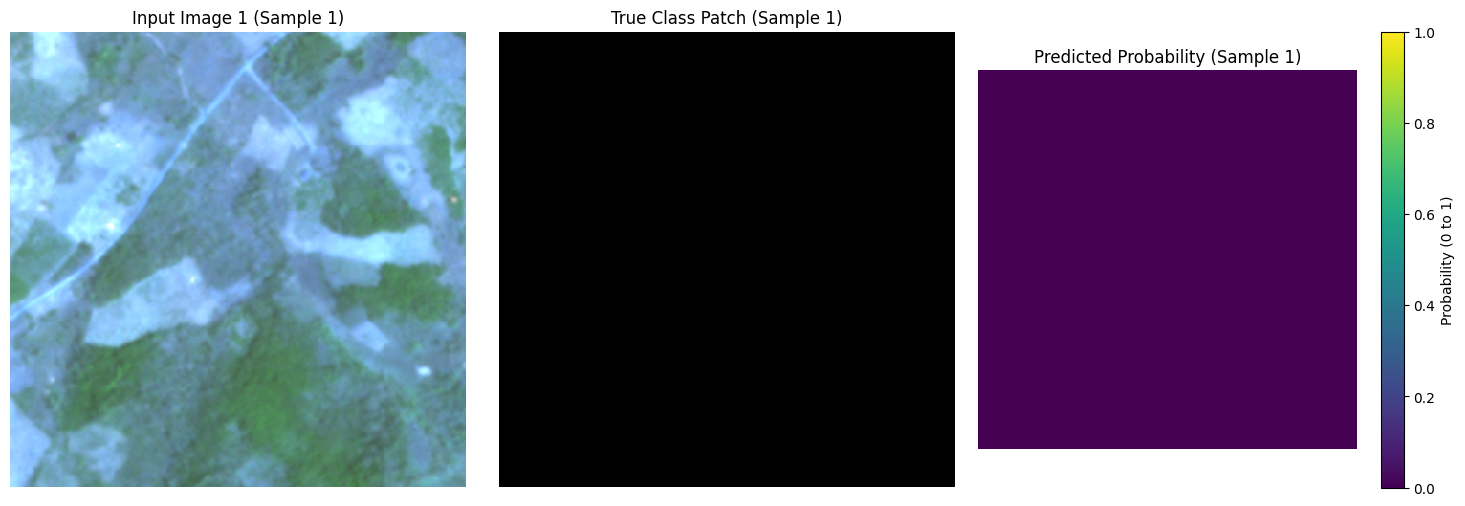

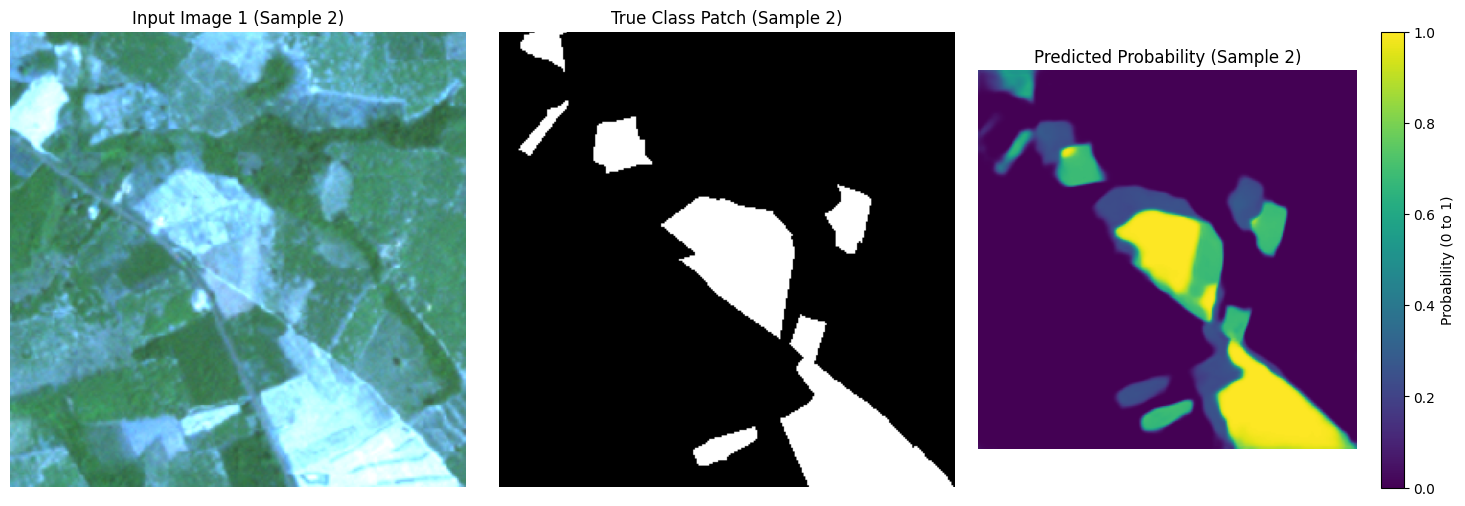

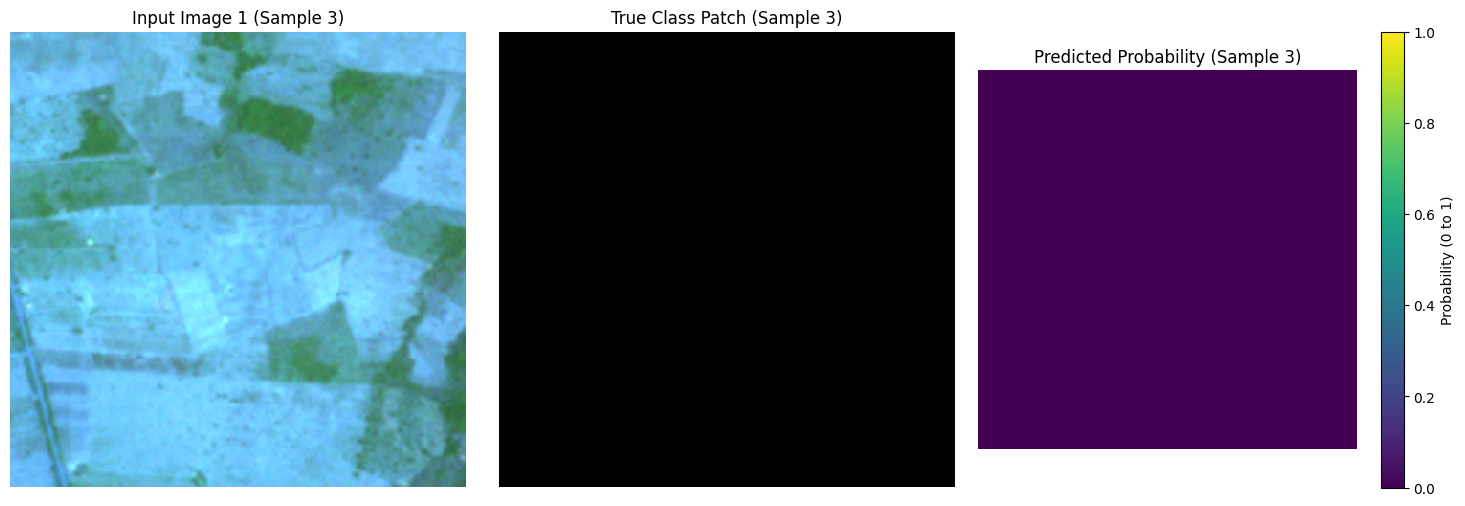

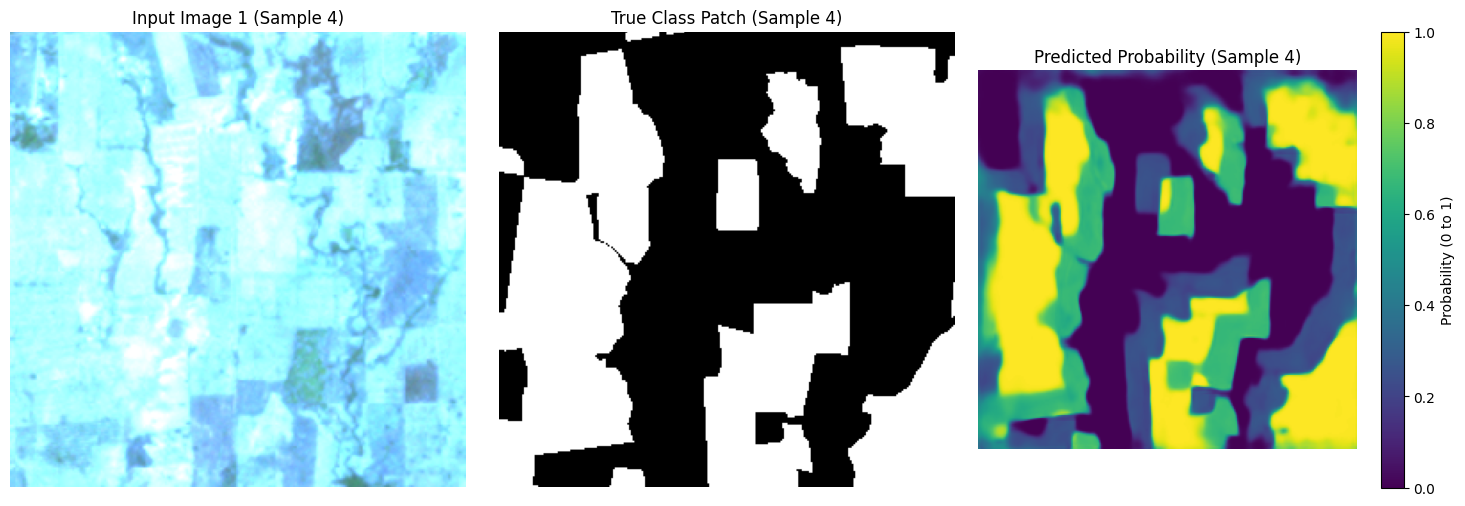

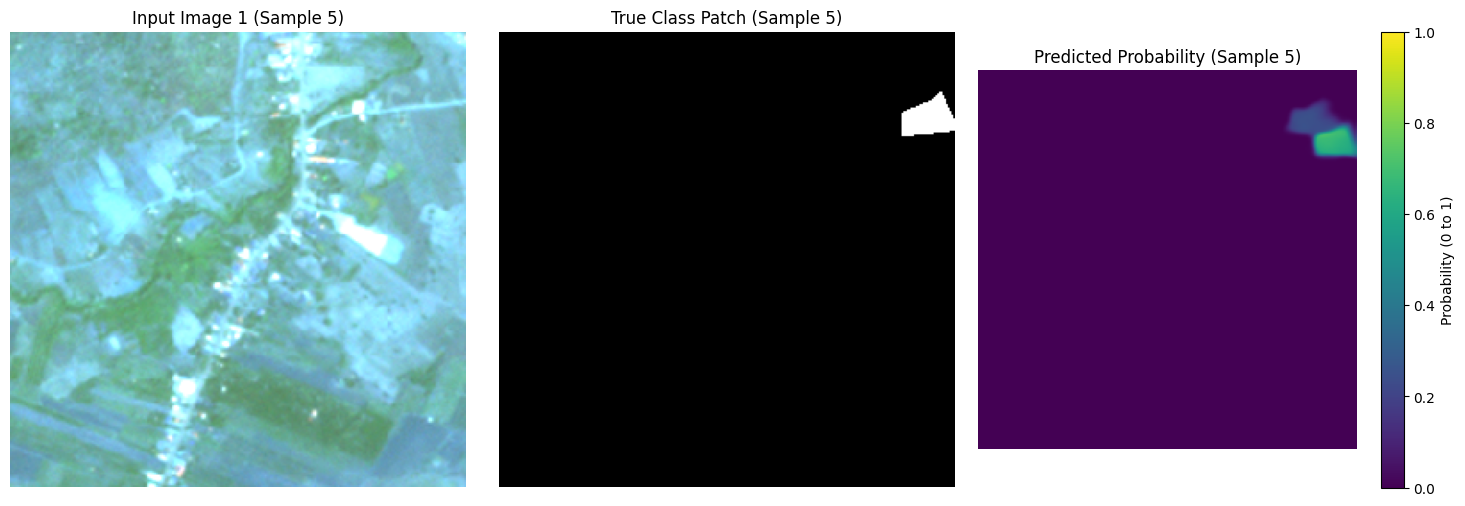

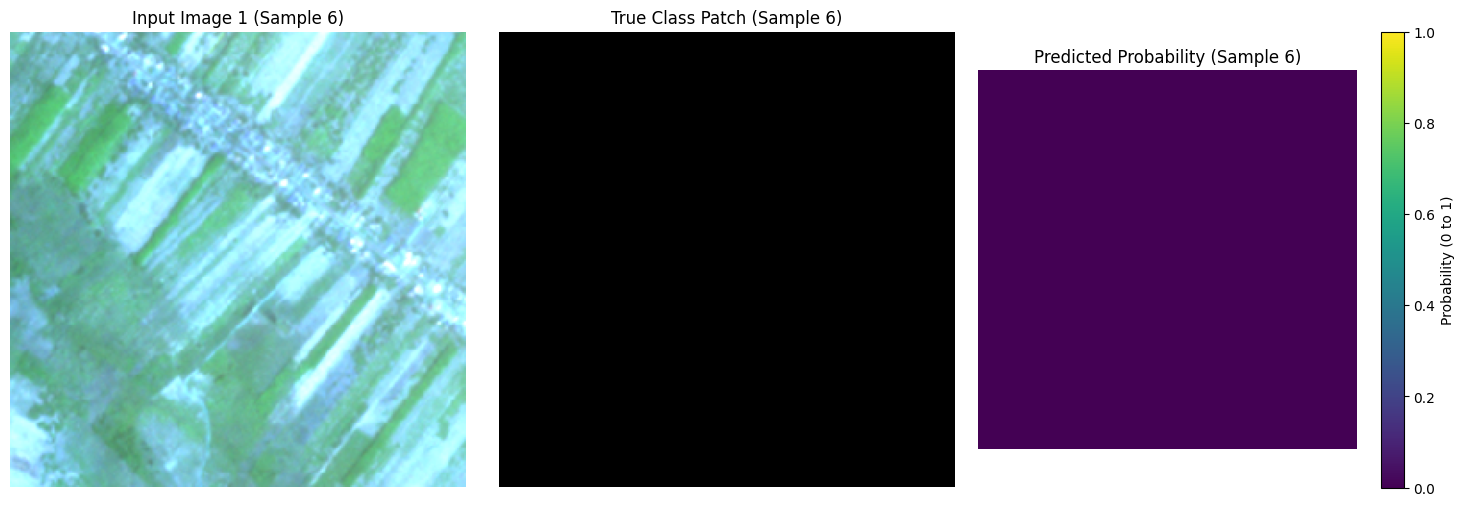

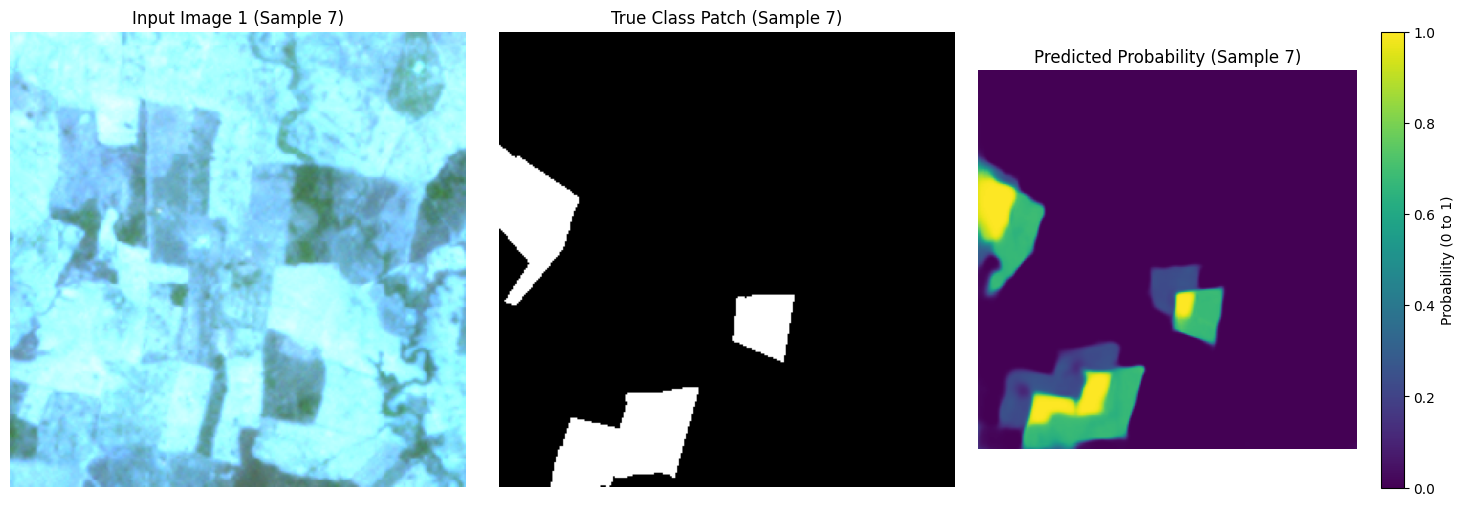

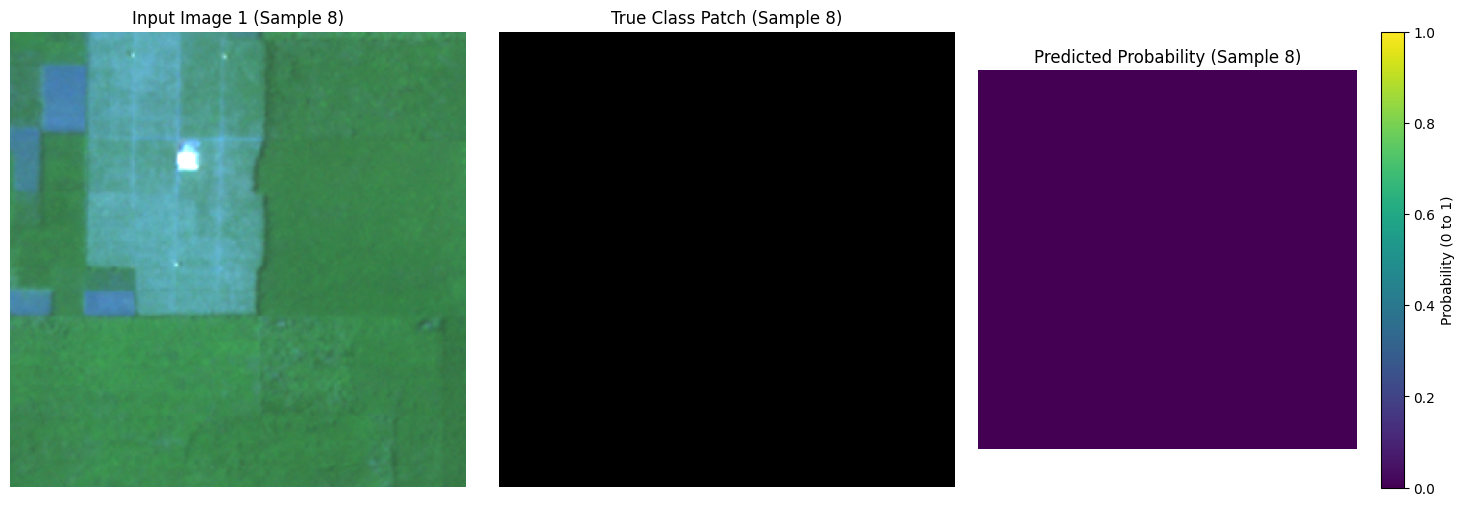

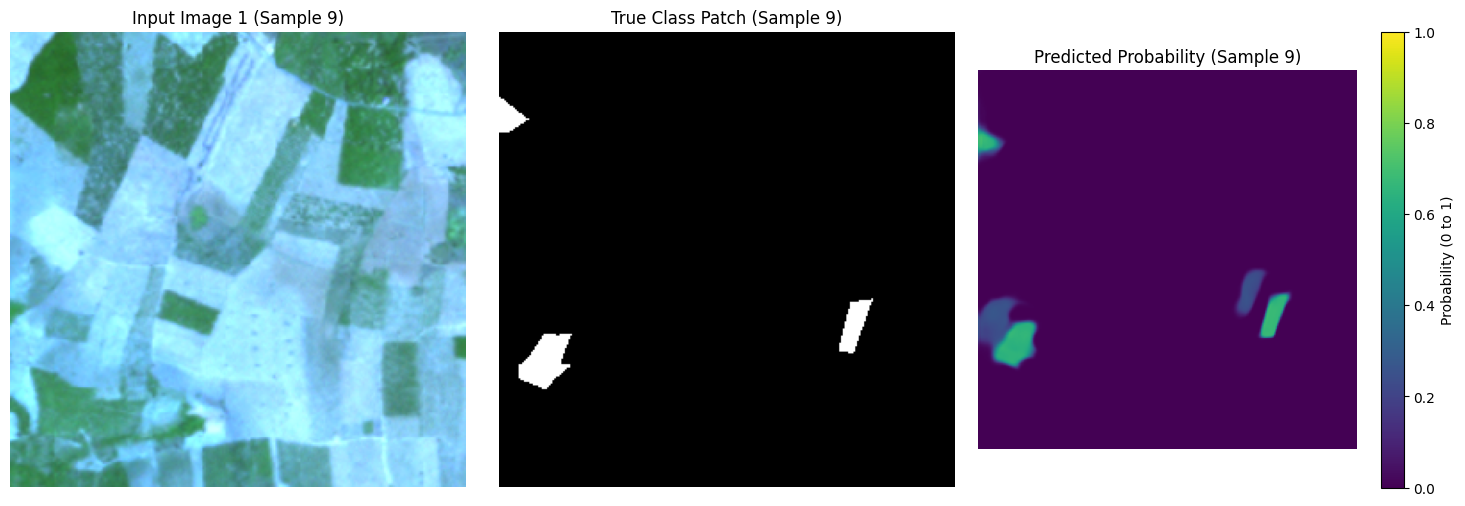

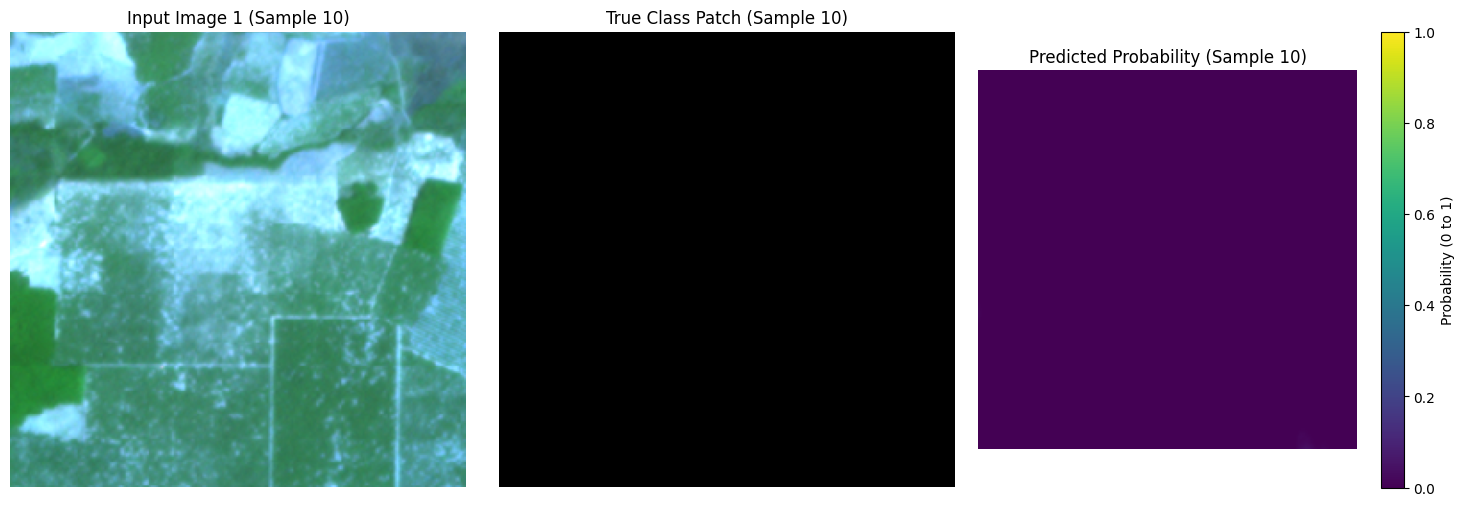

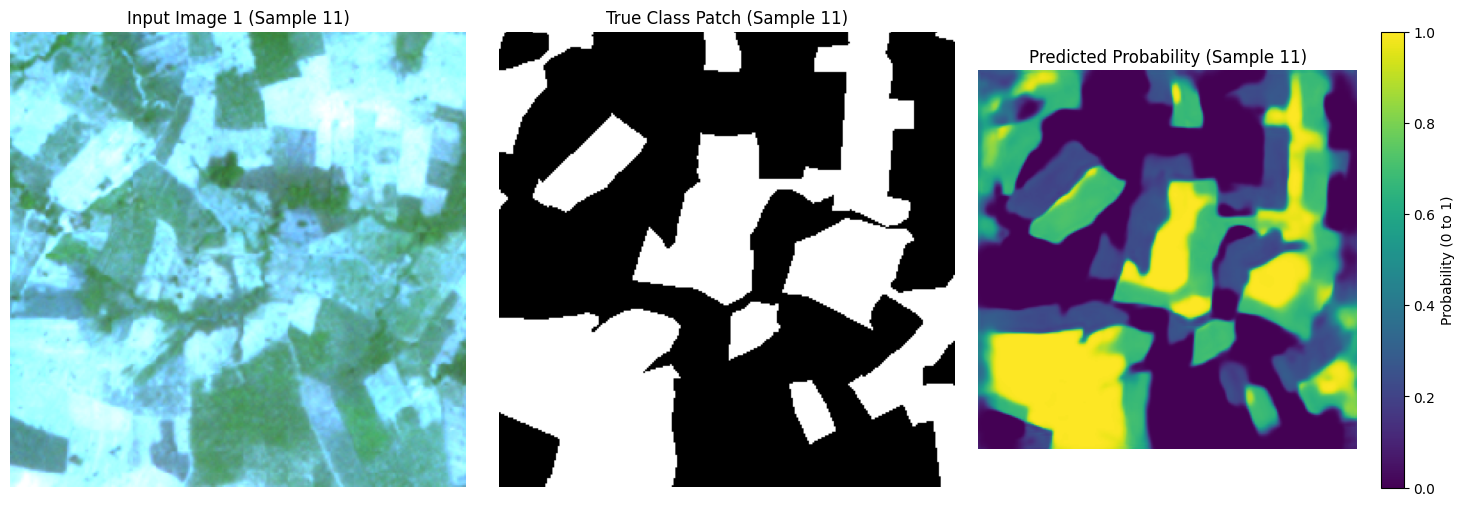

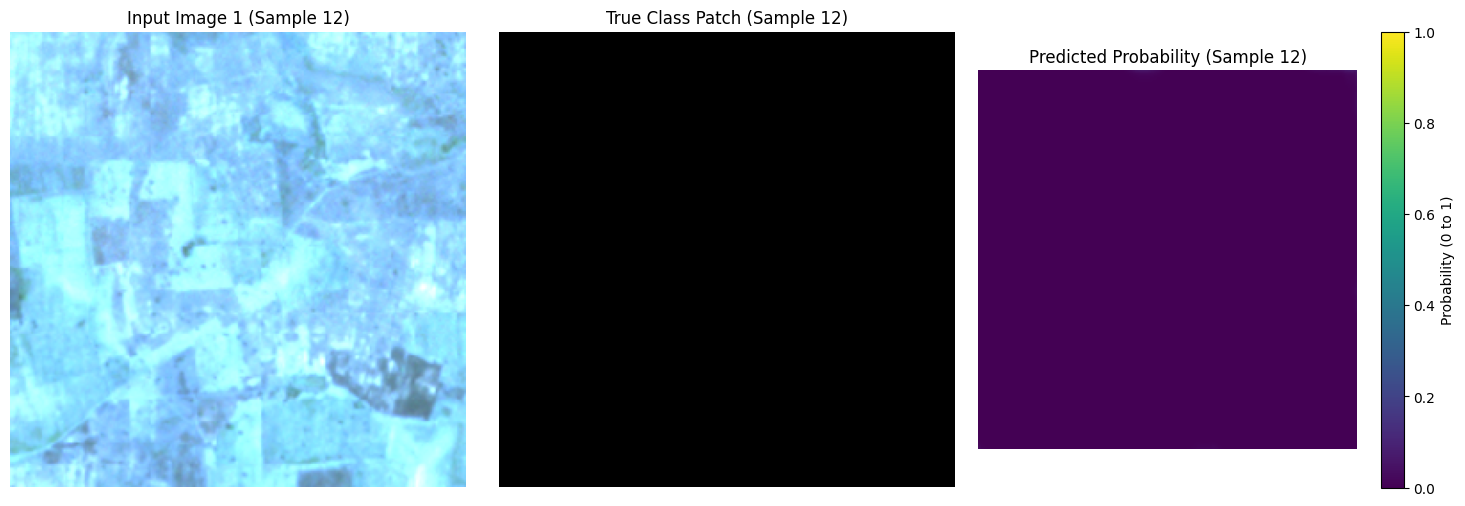

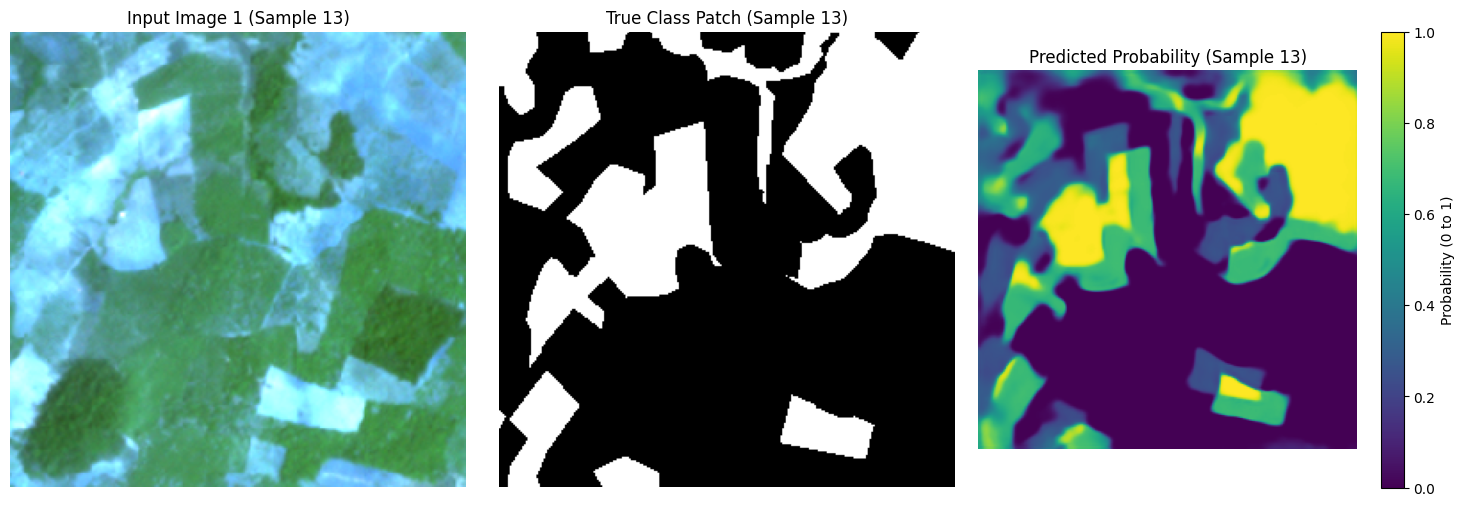

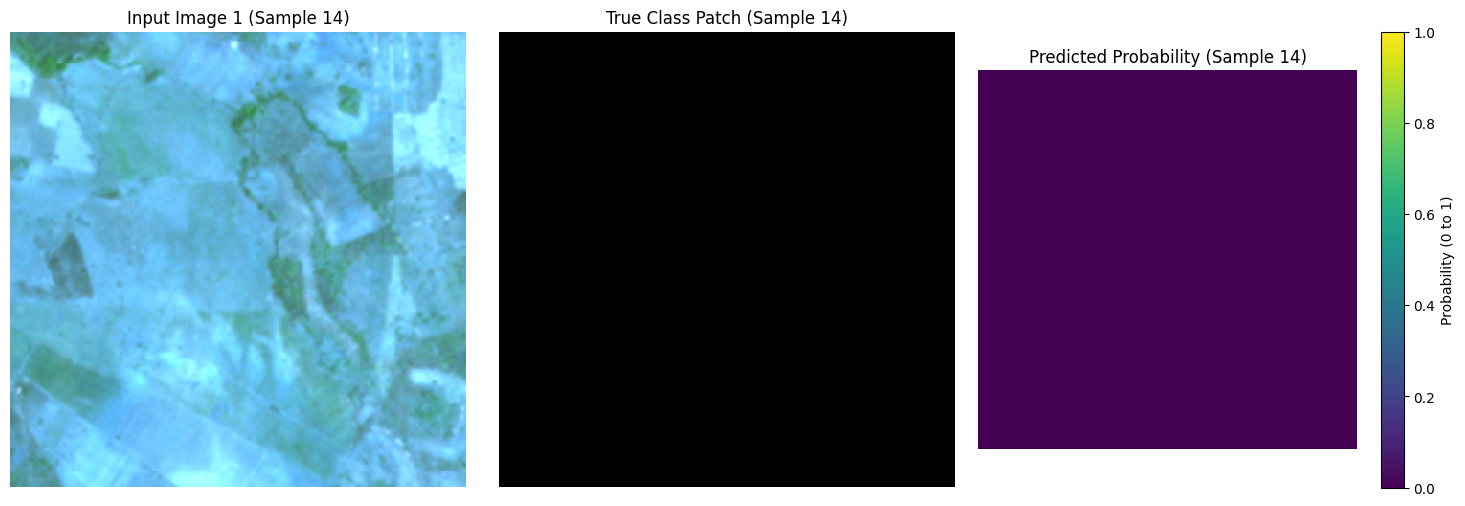

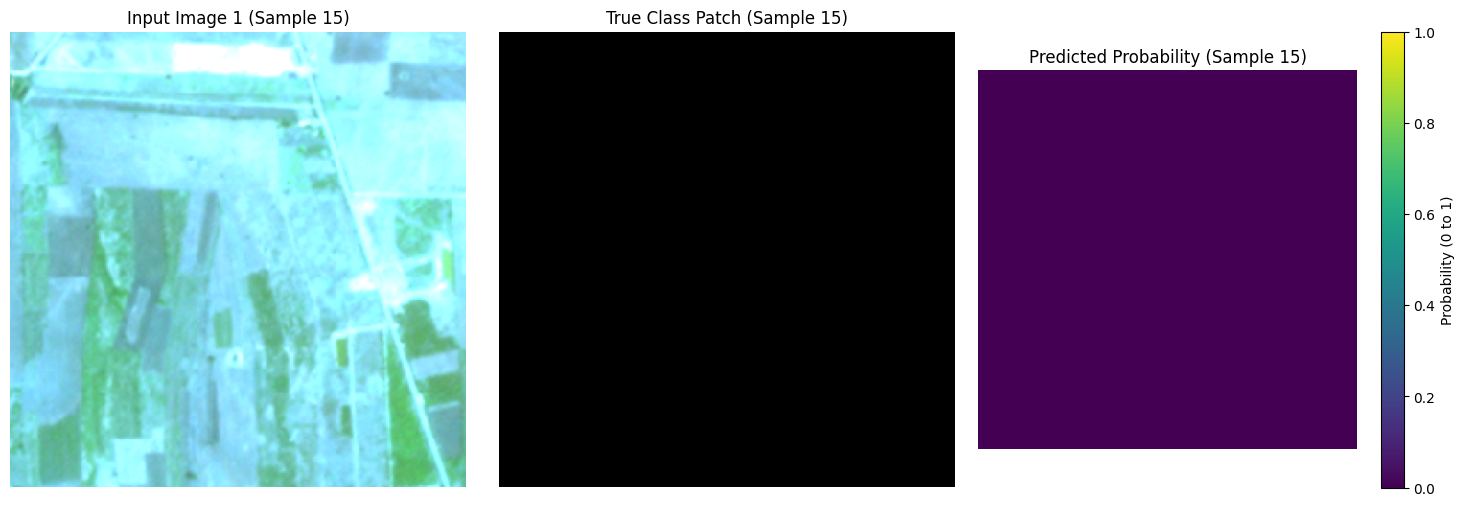

In [ ]:
import matplotlib.pyplot as plt

# Plotting function (same as before)
def plot_prediction(input_image, true_label, prediction, sample_idx):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_image[..., :3])
    axes[0].set_title(f"Input Image 1 (Sample {sample_idx})")
    axes[0].axis('off')
    axes[1].imshow(true_label, cmap='gray')
    axes[1].set_title(f"True Class Patch (Sample {sample_idx})")
    axes[1].axis('off')
    pred_prob = prediction[..., 1]
    im = axes[2].imshow(pred_prob, cmap='viridis', vmin=0, vmax=1)
    axes[2].set_title(f"Predicted Probability (Sample {sample_idx})")
    axes[2].axis('off')
    cbar = fig.colorbar(im, ax=axes[2], orientation='vertical')
    cbar.set_label('Probability (0 to 1)')
    plt.tight_layout()
    plt.show()

# Use the existing test_dataset and unet from the previous cell
print("Plotting predictions from test_dataset...")
num_samples_to_plot = 15
for batch_idx, (inputs, labels) in enumerate(test_dataset.take(1)):
    predictions = unet.predict(inputs)
    for i in range(min(num_samples_to_plot, BATCH_SIZE)):
        input_image1 = inputs['input_image1'][i].numpy()
        true_label = labels[i, ..., 1].numpy()  # Positive class channel
        pred_label = predictions[i]  # Prediction is (256, 256, 2)
        plot_prediction(input_image1, true_label, pred_label, i + 1)

In [ ]:
# !gsutil -m cp -r -n /content/unet/model/log/* gs://cbdcrop/unet/model_weight


Skipping existing item: gs://cbdcrop/unet/model_weight/model_cassava_planet_2023_m3.weights.h5
Copying file:///content/unet/model/log/planet_num_63552_cassava_2023_m3_f1_0.9803.h5 [Content-Type=application/x-hdf5]...
Copying file:///content/unet/model/log/planet_num_63552_cassava_2023_m3_f1_0.9803.keras [Content-Type=application/octet-stream]...
Copying file:///content/unet/model/log/planet_num_63552_cassava_2023_m3_f1_0.9803.weights.h5 [Content-Type=application/x-hdf5]...
